# Cross Sections of MNIST Decision Cells

## Imports and data loading

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
import torch.nn as nn
import jupyter_black
from torchsummary import summary
from sklearn.decomposition import PCA

from data_generators import data_loader_MNIST
from model_classes import LeNet
from tools import accuracy, plot_results, plot_reg_results, svb

jupyter_black.load()

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Loading MNIST dataset
in_channels = 1
train_loader, test_loader = data_loader_MNIST()

### Train function

In [4]:
def train(
    dl,
    model,
    n_epochs=2,
    l1=False,
    l1_lmbd=0.00001,
    l2=False,
    l2_lmbd=0.0001,
    l1_l2=False,
    soft_svb=False,
    soft_svb_lmbd=0.01,
    hard_svb=False,
    hard_svb_lmbd=0.001,
    jacobi_reg=False,
    jacobi_reg_lmbd=0.001,
    jacobi_det_reg=False,
    jacobi_det_reg_lmbd=0.001,
):
    losses = []
    epochs = []
    weights = []
    accuracies = []
    reg_losses = []

    for epoch in range(n_epochs):
        N = len(dl)
        for param in model.parameters():
            weights.append(param.detach().numpy().copy())
        for i, (data, labels) in enumerate(dl):
            epochs.append(epoch + i / N)
            loss_data, reg_loss_data = model.train_step(
                data,
                labels,
                l1=l1,
                l1_lmbd=l1_lmbd,
                l2=l2,
                l2_lmbd=l2_lmbd,
                l1_l2=l1_l2,
                soft_svb=soft_svb,
                soft_svb_lmbd=soft_svb_lmbd,
                jacobi_reg=jacobi_reg,
                jacobi_reg_lmbd=jacobi_reg_lmbd,
                jacobi_det_reg=jacobi_det_reg,
                jacobi_det_reg_lmbd=jacobi_det_reg_lmbd,
            )
            losses.append(loss_data)
            reg_losses.append(reg_loss_data)

        if hard_svb:
            svb(model, eps=hard_svb_lmbd)

        acc = accuracy(model, test_loader)
        accuracies.append(acc)
        model.counter = 0
        print(f"Epoch: {epoch}")
        print("Accuracy of the network on the test images: %d %%" % (100 * acc))
    return losses, reg_losses, epochs, weights, accuracies

### Hyperparameters

In [5]:
lr = 0.01
momentum = 0.9

### Training models with and without regularization

In [6]:
model_no_reg = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
model_l2_reg = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
model_jacobi_reg = LeNet(lr=lr, momentum=momentum, in_channels=in_channels).to(device)
n_epochs = 2
losses1, reg_losses1, epochs1, weights1, accuracies1 = train(
    train_loader, model_no_reg, n_epochs
)
losses2, reg_losses2, epochs2, weights2, accuracies2 = train(
    train_loader, model_l2_reg, n_epochs, l2=True, l2_lmbd=0.01
)
losses3, reg_losses3, epochs3, weights3, accuracies3 = train(
    train_loader, model_jacobi_reg, n_epochs, jacobi_reg=True, jacobi_reg_lmbd=1
)

Epoch: 0
Accuracy of the network on the test images: 82 %
Epoch: 1
Accuracy of the network on the test images: 85 %
Epoch: 0
Accuracy of the network on the test images: 36 %
Epoch: 1
Accuracy of the network on the test images: 75 %
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 0
Accuracy of the network on the test images: 75 %
calculated jacobi
calculated jacobi
calculated jacobi
Epoch: 1
Accuracy of the network on the test images: 86 %


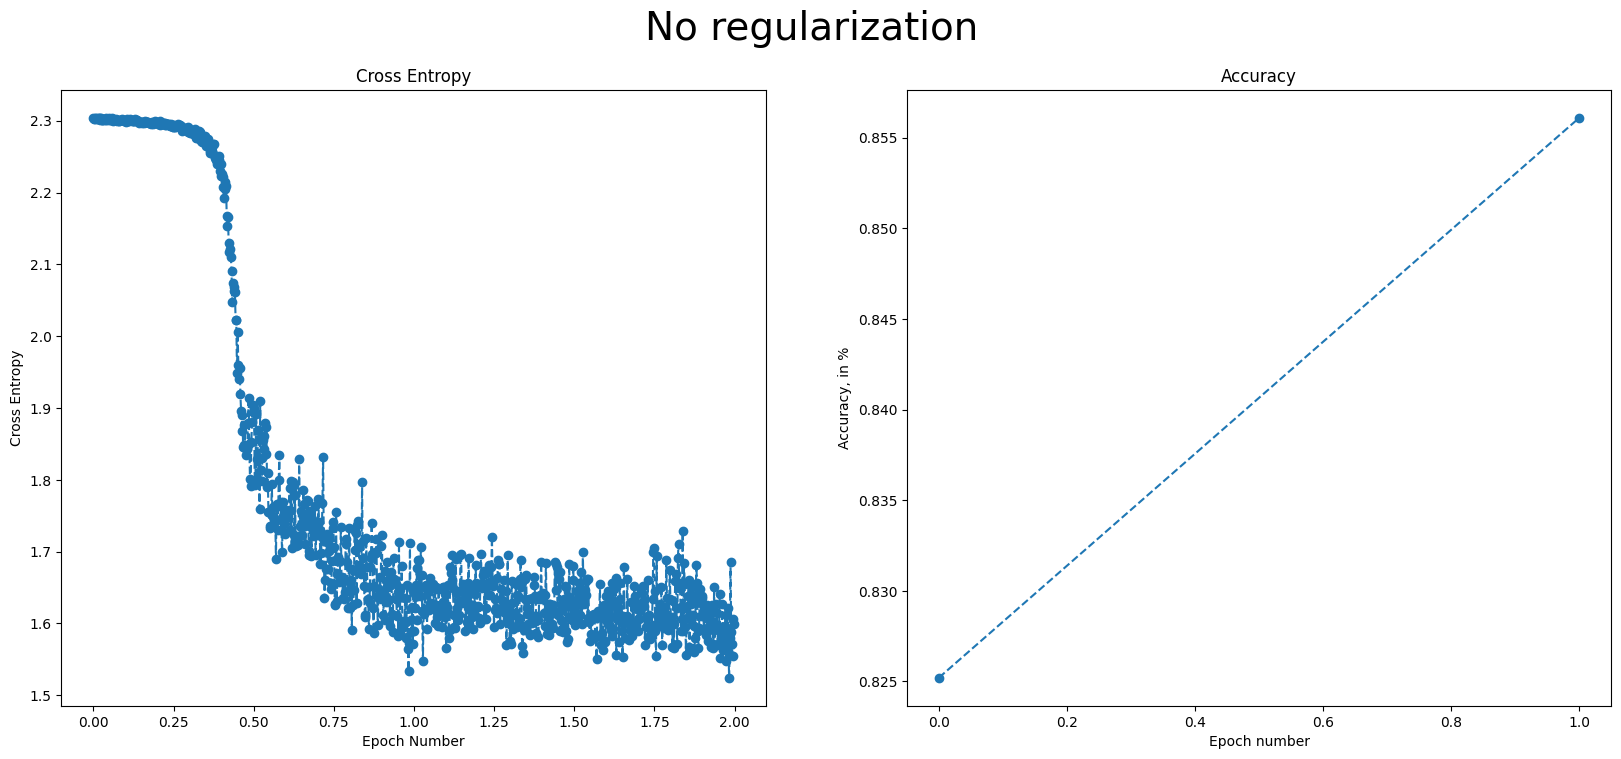

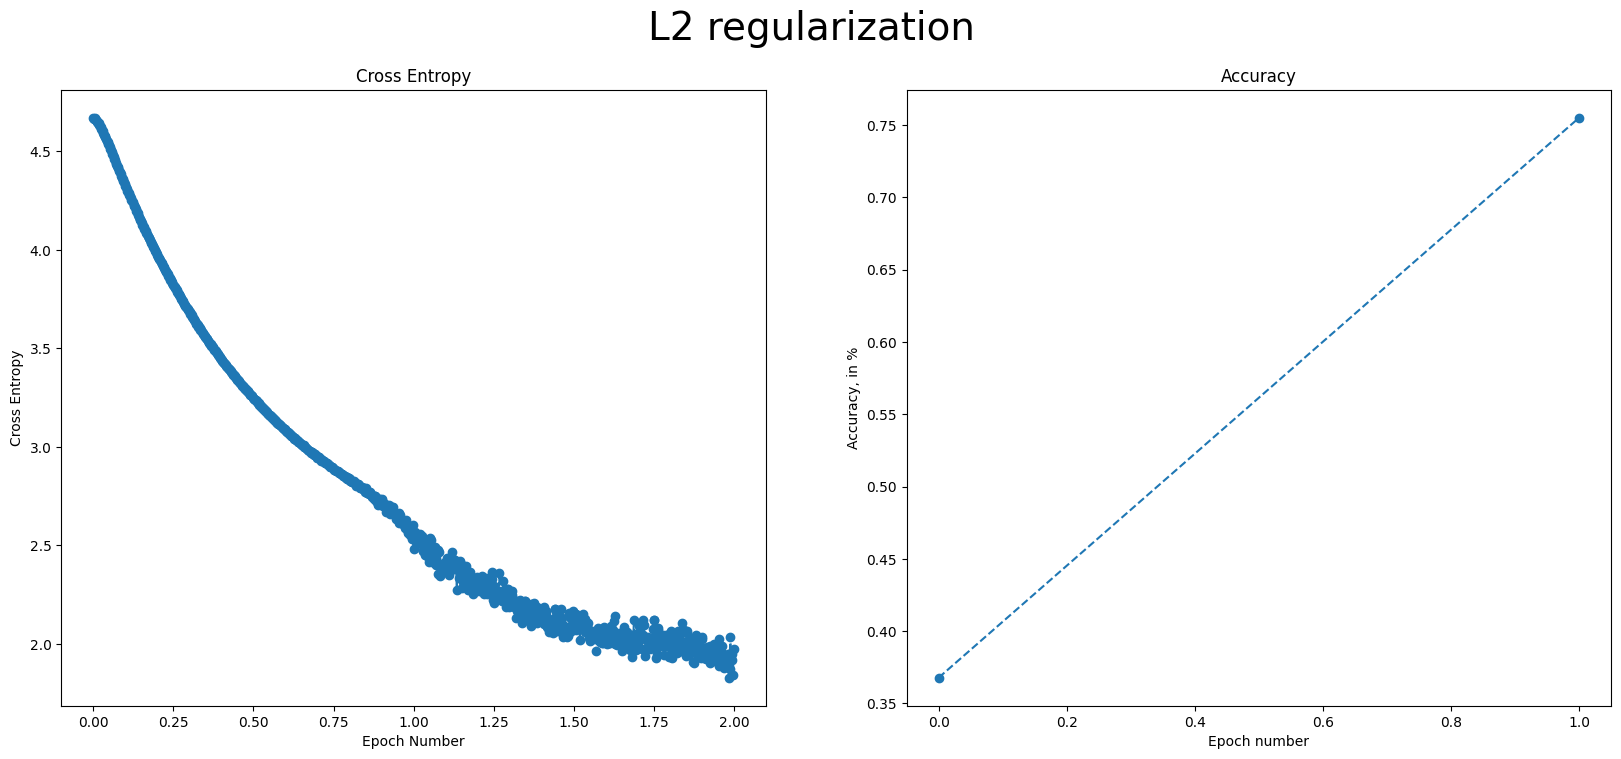

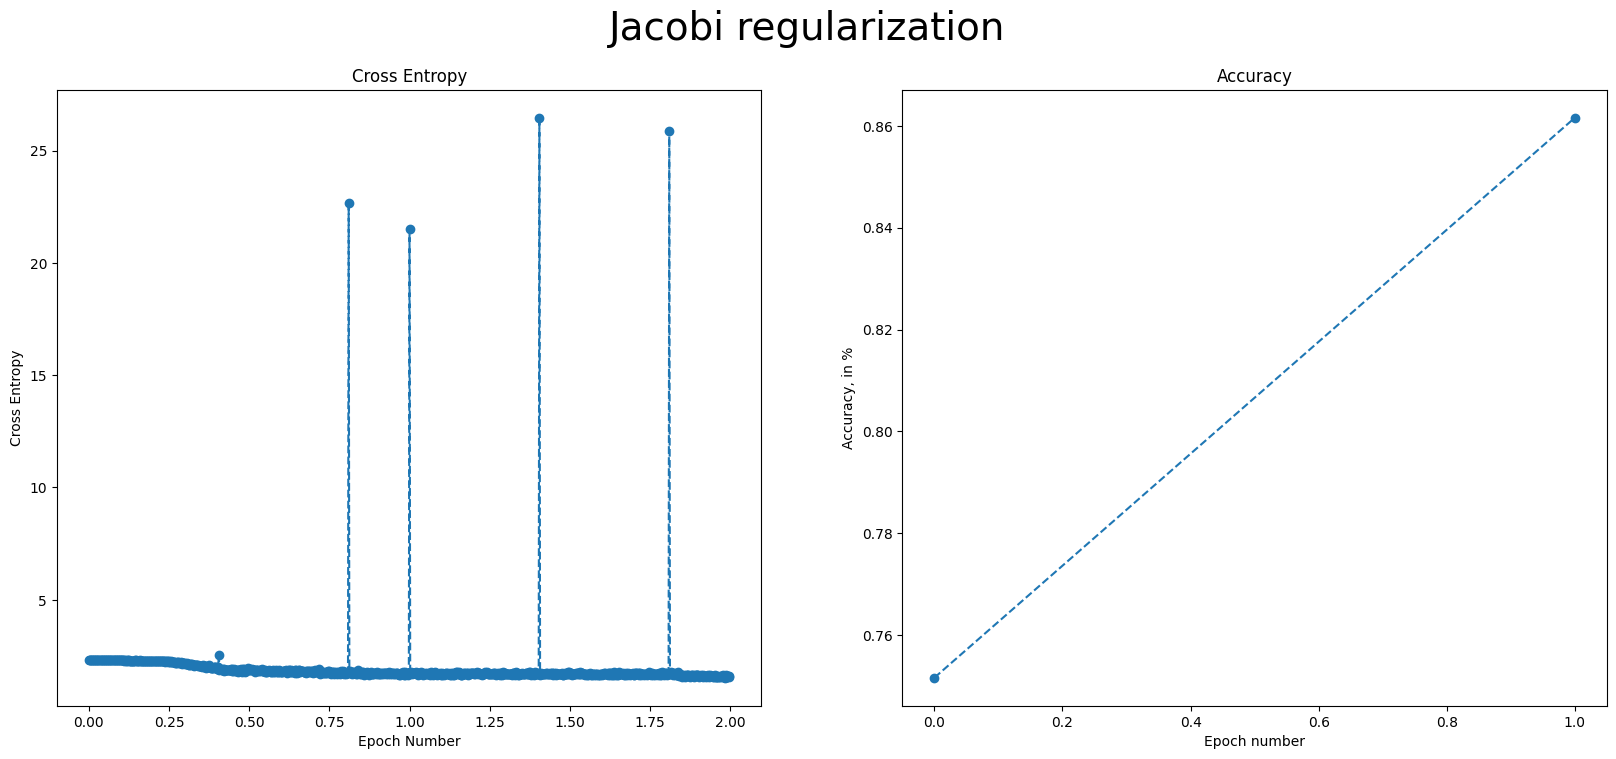

In [7]:
plot_results(epochs1, losses1, accuracies1, title="No regularization")
plot_results(epochs2, losses2, accuracies2, title="L2 regularization")
plot_results(epochs3, losses3, accuracies3, title="Jacobi regularization")

### Finding cross-sections

In [80]:
def visualize_decision_cells(
    model, train_loader, test_loader, regularization=None, seed=None
):
    if seed is not None:
        np.random.seed(seed)

    # Perform PCA on the training dataset
    train_data = []
    train_labels = []

    for images, labels in train_loader:
        train_data.append(images.view(-1, 32 * 32).numpy())
        train_labels.append(labels.numpy())

    train_data = np.concatenate(train_data)
    train_labels = np.concatenate(train_labels)

    pca = PCA(n_components=2)
    pca.fit(train_data)

    # Select a random test sample and its corresponding label
    """
    sample, label = None, None
    for images, labels in test_loader:
        sample, label = images[0], labels[0]
        break
    sample = sample.unsqueeze(0)
    """
    import random
    import torch.utils.data as data

    # Get the length of the test dataset
    test_dataset = test_loader.dataset
    num_test_samples = len(test_dataset)

    # Create a random sampler for the test dataset
    random_sampler = data.RandomSampler(test_dataset)

    # Choose a random index from the test dataset
    random_index = random.randint(0, num_test_samples - 1)

    # Get the random test sample using the random index
    sample = test_dataset[random_index][0].unsqueeze(0)

    sample = sample.unsqueeze(0)

    # Flatten the sample and project it onto the principal components
    sample_flat = sample.view(-1).detach().numpy().squeeze()
    sample_pca = pca.transform(sample_flat.reshape(1, -1))

    # Create a grid in the chosen dimensions
    grid_size = 100
    xx, yy = np.meshgrid(
        np.linspace(-10, 10, grid_size), np.linspace(-10, 10, grid_size)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Transform the grid back to the input space
    grid_inverse = pca.inverse_transform(grid)
    input_space = torch.tensor(grid_inverse, dtype=torch.float32)

    # Calculate the model predictions and softmax probabilities
    with torch.no_grad():
        output = model(input_space.view(-1, 1, 32, 32))
        probs = torch.softmax(output, dim=1)

    # Find the maximum probability and corresponding class
    max_probs, max_classes = torch.max(probs, 1)

    # Create the scatter plot with the calculated grid probabilities
    fig, ax = plt.subplots(figsize=(10, 10))
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    cmap = ListedColormap(colors)
    max_probs_norm = (max_probs - max_probs.min()) / (max_probs.max() - max_probs.min())

    levels = np.linspace(0, 1, 11)
    contour_colors = [cmap(np.linalg.norm(level)) for level in levels[1:-1]]
    contour_colors.insert(0, (0, 0, 0, 0))  # make the lowest level transparent
    contour_colors.append((0, 0, 0, 0))  # make the highest level transparent

    # Plot filled contours at specified levels
    ax.contourf(
        xx,
        yy,
        max_probs_norm.reshape(xx.shape),
        levels=levels,
        colors=contour_colors,
    )

    sc = ax.scatter(
        xx.ravel(),
        yy.ravel(),
        c=max_classes,
        cmap=cmap,
        alpha=max_probs_norm,
        edgecolors="k",
        linewidths=0.5,
        marker="s",
    )

    # Plot the test sample with a circle indicating the closest decision boundary
    dist_to_boundary = torch.min(max_probs)
    circle = plt.Circle(
        (sample_pca[0, 0], sample_pca[0, 1]),
        dist_to_boundary,
        color="k",
        fill=False,
    )
    ax.add_artist(circle)

    ax.scatter(
        sample_pca[0, 0],
        sample_pca[0, 1],
        c="k",
        marker="o",
        s=100,
        edgecolors="w",
        linewidths=1,
    )

    ax.set_title(
        f"Decision Cells Visualization ({regularization or 'No Regularization'})"
    )

    # Add a color bar
    # cbar = plt.colorbar(sc, ticks=range(10), ax=ax)
    # cbar.set_label("Digits", rotation=270, labelpad=15)

    # Create a legend with the label for each class
    import matplotlib.patches as mpatches

    handles = []
    for i in range(10):
        handle = mpatches.Patch(color=colors[i], label=str(i))
        handles.append(handle)
    ax.legend(handles=handles)

    # Center the plot around the point and the circle
    ax.set_xlim(
        sample_pca[0, 0] - 30 * dist_to_boundary,
        sample_pca[0, 0] + 30 * dist_to_boundary,
    )
    ax.set_ylim(
        sample_pca[0, 1] - 30 * dist_to_boundary,
        sample_pca[0, 1] + 30 * dist_to_boundary,
    )

    plt.show()

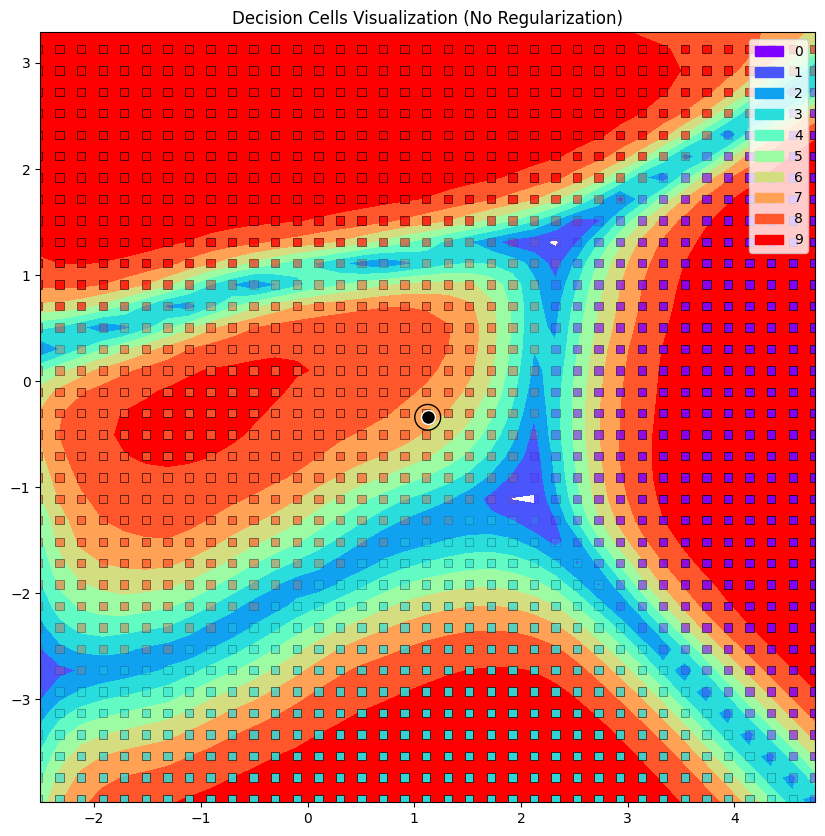

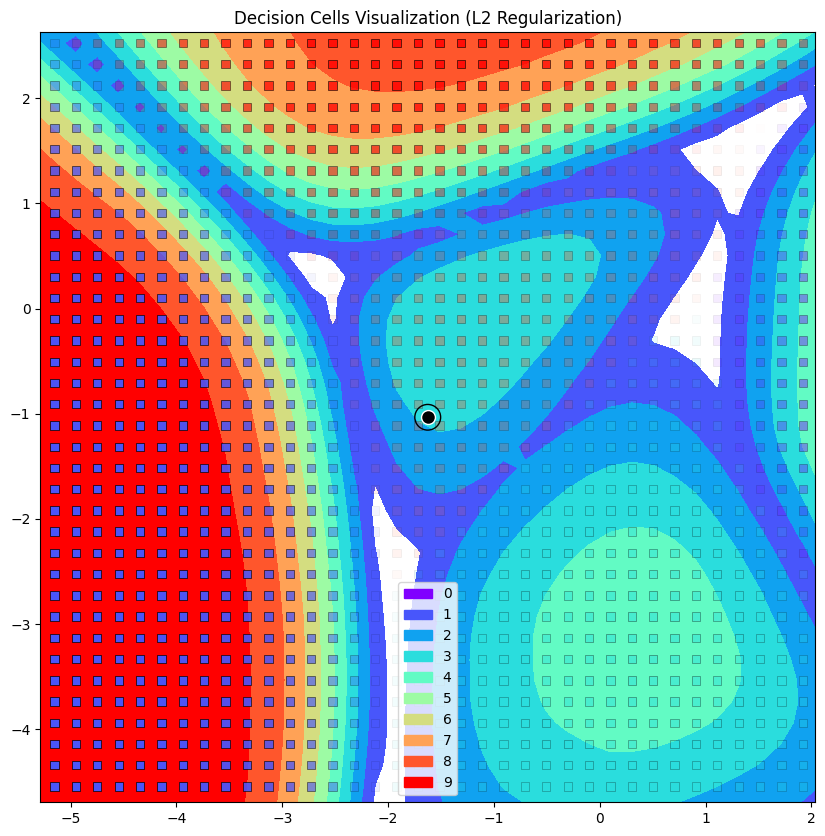

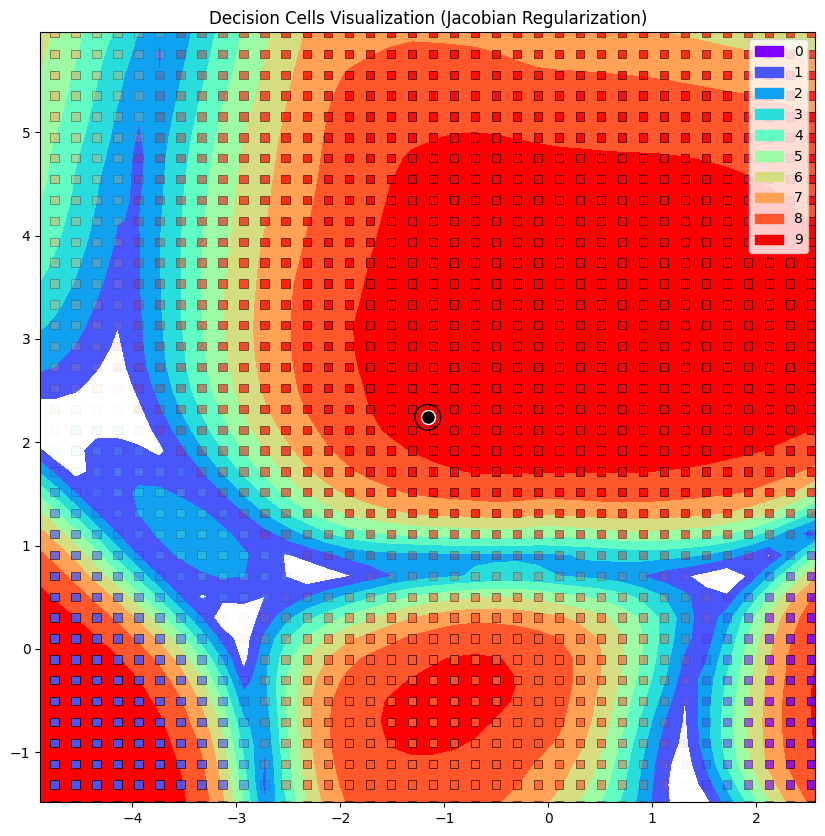

In [81]:
# Visualize decision cells without regularization
visualize_decision_cells(
    model_no_reg, train_loader, test_loader, regularization=None, seed=1
)

# Visualize decision cells with L2 regularization
visualize_decision_cells(
    model_l2_reg, train_loader, test_loader, regularization="L2 Regularization", seed=1
)

# Visualize decision cells with Jacobian regularization
visualize_decision_cells(
    model_jacobi_reg,
    train_loader,
    test_loader,
    regularization="Jacobian Regularization",
    seed=1,
)